# STEP #0: PROBLEM STATEMENT

- In this project, we will build, train and test a model to classify fashion items using TensorFlow 2.0 similar to what we have already done in the past
- What's new is that we are going to deploy the model in practice using Tensorflow Serving.
- Fashion training set consists of 70,000 images divided into 60,000 training and 10,000 testing samples. Dataset sample consists of 28x28 grayscale image, associated with a label from 10 classes.

- The 10 classes are as follows:  
  - 0 => T-shirt/top
  - 1 => Trouser
  - 2 => Pullover
  - 3 => Dress
  - 4 => Coat
  - 5 => Sandal
  - 6 => Shirt
  - 7 => Sneaker
  - 8 => Bag
  - 9 => Ankle boot

- Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.

- Note: TF serving code section is based upon the TensorFlow 2.0 Documentation: https://www.tensorflow.org/tfx/serving/tutorials/Serving_REST_simple

## STEP #1: IMPORT PACKAGES

In [1]:
import tensorflow as tf
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import tempfile


# STEP #2: IMPORT DATASET

In [2]:
# import Fashion MNIST Dataset using Keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Data Normalization -> Between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0


In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
X_test.shape

(10000, 28, 28)

In [6]:
# Reshape training data to be = (60000, 28, 28, 1) instead of (60000, 28,28)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)


In [8]:
X_train.shape

(60000, 28, 28, 1)

In [9]:
# Do the same for the testing dataset
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [10]:
X_test.shape

(10000, 28, 28, 1)

In [11]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [12]:
len(X_train)

60000

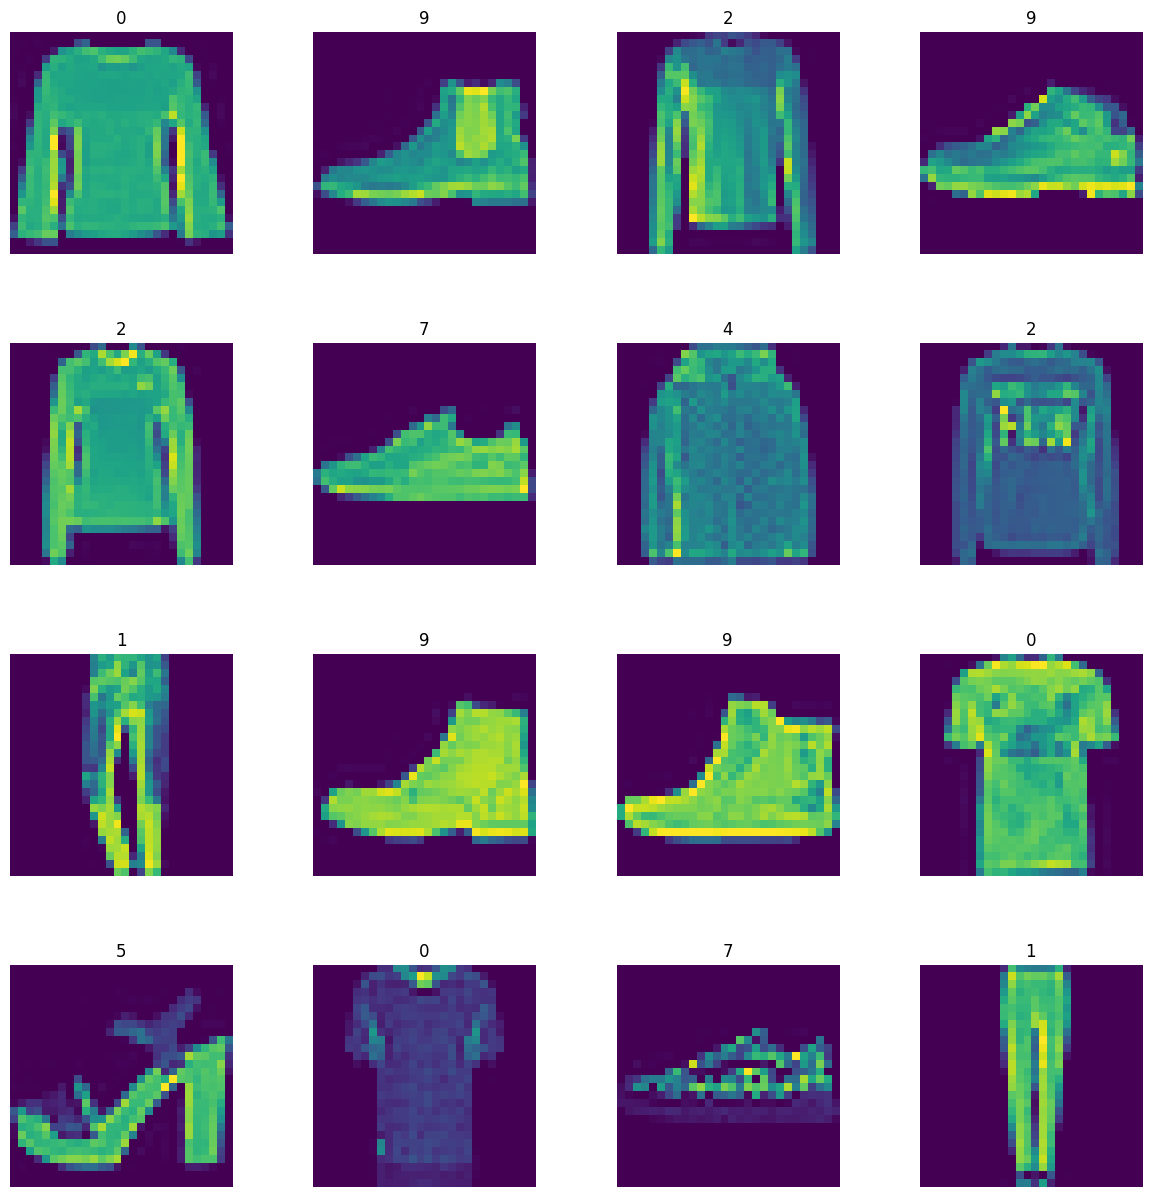

In [13]:
W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))
axes = axes.ravel()

n_training = len(X_train)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(X_train[index].reshape(28,28))
    axes[i].set_title(y_train[index])
    axes[i].axis('off')

plt.subplots_adjust(hspace = 0.4)

# STEP #3: BUILD, TRAIN AND TEST THE MODEL

In [16]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (28,28,1)))
cnn.add(tf.keras.layers.MaxPooling2D(2,2))

cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(64, activation = 'relu'))

cnn.add(tf.keras.layers.Dense(10, activation = 'softmax'))
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         495,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 515,146 (1.97 MB)

 Trainable params: 515,146 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
epochs = 5

cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [20]:
cnn.fit(X_train, y_train, epochs=epochs)

test_loss, test_acc = cnn.evaluate(X_test, y_test)
print('\nTest accuracy: {}'.format(test_acc))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8041 - loss: 0.5470
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9034 - loss: 0.2650
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9236 - loss: 0.2104
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9359 - loss: 0.1753
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9466 - loss: 0.1448
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9202 - loss: 0.2439

Test accuracy: 0.9192000031471252


# STEP #4: SAVE THE MODEL

- We now need to save our trained model and it has to be saved in a SavedModel format.
- The model will have a version number and will be saved in a structured directory
- tf.saved_model.simple_save is a function used to build a saved model that is suitable for serving using Tensorflow Serving.
- After the model is saved, we can now use TensorFlow Serving to start making inference requests using a specific version of our trained model "servable".
- Use SavedModel to save and load your model—variables, the graph, and the graph's metadata.
- This is a language-neutral, recoverable, hermetic serialization format that enables higher-level systems and tools to produce, consume, and transform TensorFlow models.
- simple_save offers a very easy way to save a model as follows:

  - simple_save(session,
            export_dir,
            inputs={"x": x, "y": y},
            outputs={"z": z})
            
- Check this out for more information:
https://www.tensorflow.org/guide/saved_model

In [21]:
# Let's obtain a temporary storage directory
MODEL_DIR = tempfile.gettempdir()

In [22]:
MODEL_DIR

'/tmp'

In [23]:
# Let's specify the model version, choose #1 for now
version = 1

In [24]:
# Let's join the temp model directory with our chosen version number
# The expected result will be = '\tmp\version number'
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /tmp/1



In [29]:
# Let's save the model using simple_save
# If the directory already exists, we will remove it using '!rm'
# rm removes each file specified on the command line.

if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(cnn, export_path)


In [ ]:
!ls -l {export_path}

total 100
-rw-r--r-- 1 root root 97603 Nov 14 04:14 saved_model.pb
drwxr-xr-x 2 root root  4096 Nov 14 04:14 variables


# STEP #5: EXPLORE OUR SAVED MODEL

- saved_model_cli will be used to explore MetaGraphDefs (the models) and SignatureDefs (the methods you can call) in our SavedModel.
- A MetaGraph is a dataflow graph, plus its associated variables, assets, and signatures.
- A signature is the set of inputs to and outputs from a graph.

In [30]:
# Now we can view our saved model
!saved_model_cli show --dir {export_path} --all

2024-08-27 17:13:32.596018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 17:13:32.619051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 17:13:32.624484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 17:13:33.746269: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1724778815.416619    3674 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

# STEP #6: SERVE THE MODEL USING TENSORFLOW SERVING

  # STEP 6.1: Let's add tensorflow-model-server package to our list of packages

In [31]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   6908      0 --:--:-- --:--:-- --:--:--  6924
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:7 https:/

# Step 6.2: Let's install tensorflow model server:

In [32]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 50 not upgraded.
Need to get 615 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.17.0 [615 MB]
Fetched 615 MB in 9s (66.4 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 123595 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.17.0_all.deb ...
Unpacking tensorflow-model-server (2.17.0) ...
Setting up tensorflow-model-server (2.17.0) ...


# Step 6.3: Let's run TensorFlow serving

- We will load our model and start making inferences (predictions) based on it.
- There are some important parameters:

  - rest_api_port: The port that you'll use for REST requests.
  - model_name: You'll use this in the URL of REST requests. You can choose any name
  - model_base_path: This is the path to the directory where you've saved your model.
  
- For more information regarding REST, check this out:
https://www.codecademy.com/articles/what-is-rest
- REST is a revival of HTTP in which http commands have semantic meaning.

In [33]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [34]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


In [ ]:
!tail server.log

2019-11-14 04:18:24.087957: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2019-11-14 04:18:24.089500: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-11-14 04:18:24.103356: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-11-14 04:18:24.127960: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 41568 microseconds.
2019-11-14 04:18:24.128545: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2019-11-14 04:18:24.128635: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
2019-11-14 04:18:24.129809: I tensorflow_serving/mode

- **Congratulations! now we have successfully loaded a servable version of our model {name: fashion_model version: 1}**

# STEP 6.4: Let's start making requests in TensorFlow Serving

In [35]:
def show(idx, title):
  plt.figure()
  plt.imshow(X_test[idx].reshape(28,28))
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})


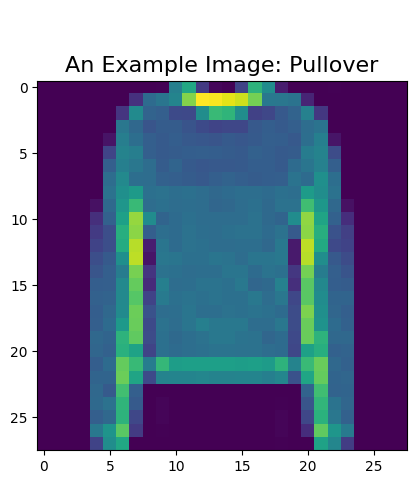

In [36]:
rando = random.randint(0,len(X_test)-1)
show(rando, 'An Example Image: {}'.format(class_names[y_test[rando]]))

In [37]:
# Let's create a JSON object and make 3 inference requests
data = json.dumps({"signature_name": "serving_default", "instances": X_test[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


In [38]:
!pip install -q requests


In [39]:

import requests


In [41]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text).get('predictions', 'Key not found')


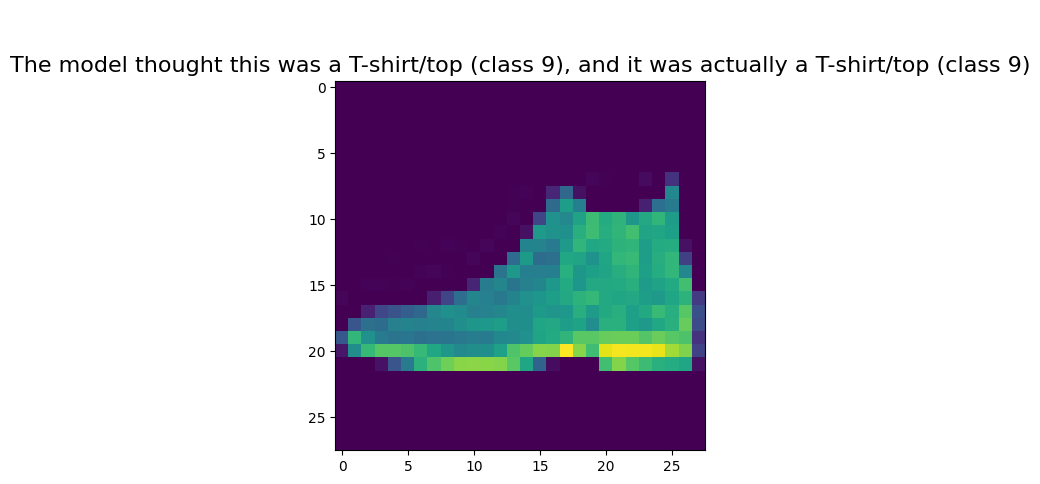

In [42]:

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], y_test[0], class_names[np.argmax(predictions[0])], y_test[0]))

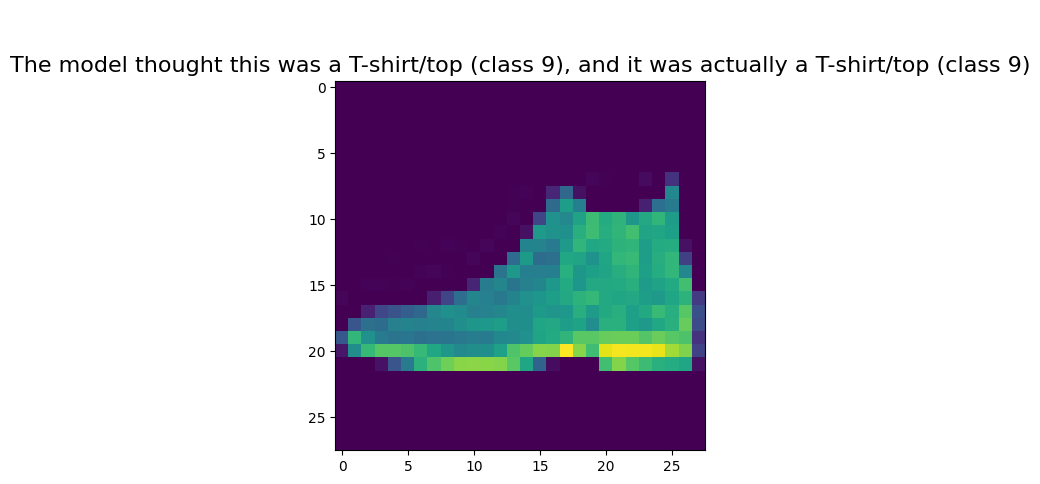

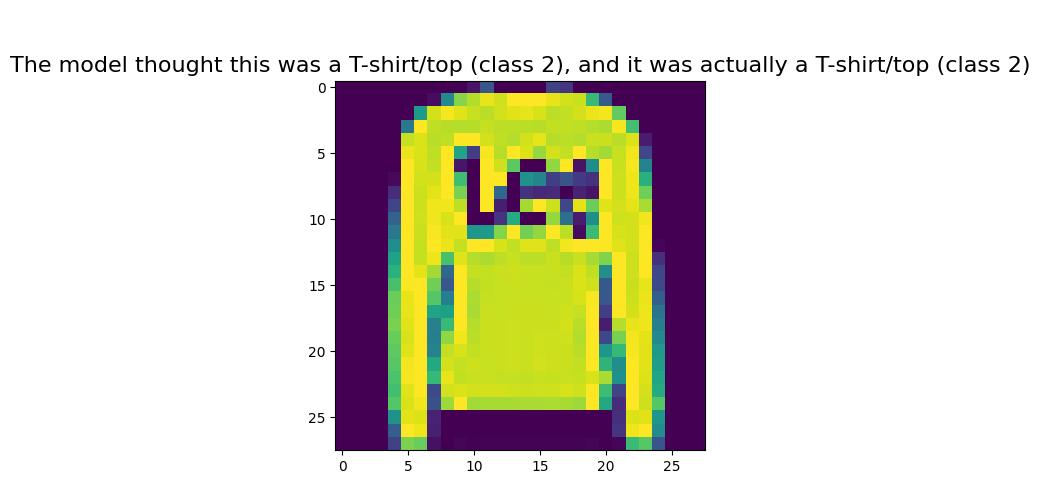

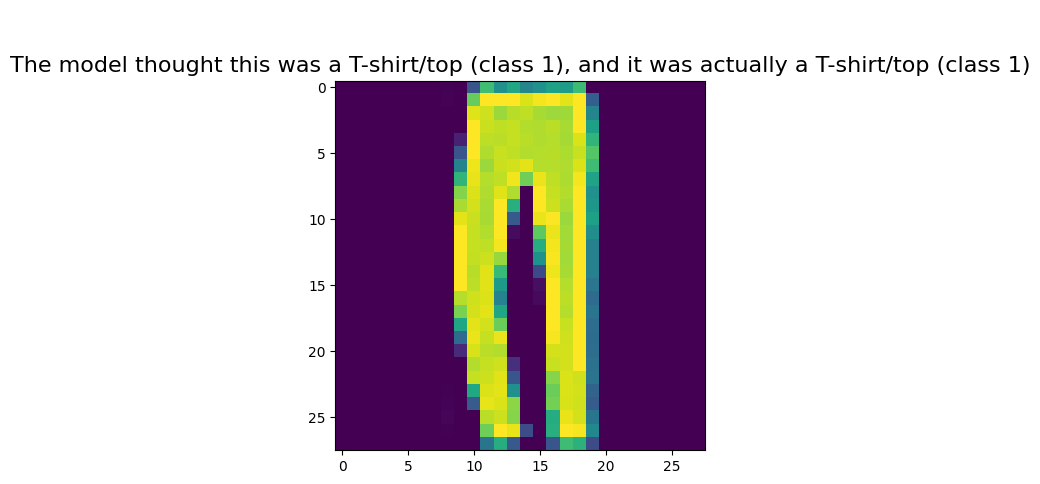

In [44]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text).get('predictions', 'Key not found')

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], y_test[i], class_names[np.argmax(predictions[i])], y_test[i]))